# Gravity Model

Everyone wants to see the map first, so here it is. In this article we will automate some of the analysis done in Alon Levy's [Streaming High-Speed Rail Crayoning](https://pedestrianobservations.com/2021/03/20/streaming-high-speed-rail-crayoning/). Mostly we will focus on the Gravity Model which is explained below.

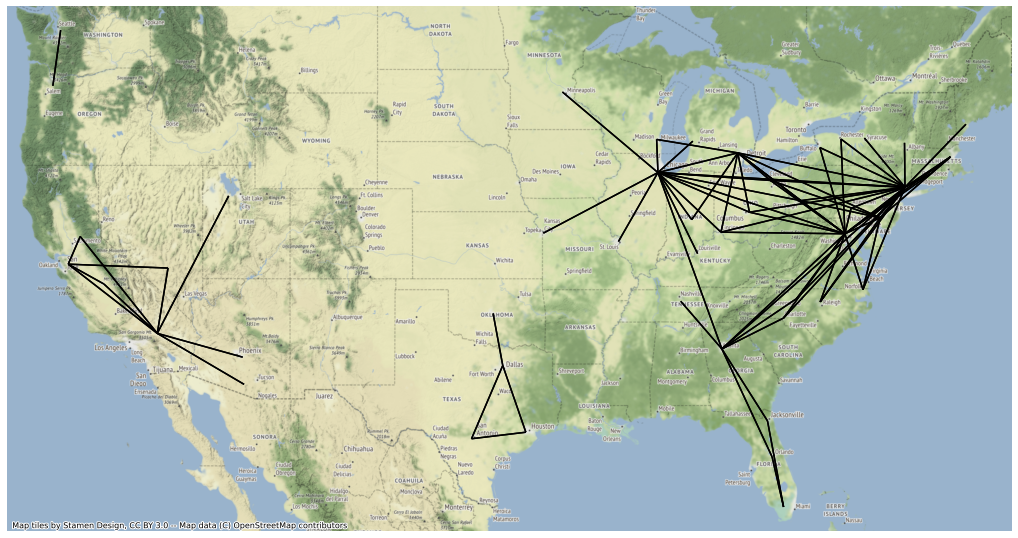

First we will import the libraries necessary for gathering data, performing our analysis, and plotting the results.

In [8]:
import contextily as ctx
import folium
import geopandas
from haversine import haversine
import numpy as np
import pandas
from shapely.geometry import Point, LineString
import ssl; ssl._create_default_https_context = ssl._create_stdlib_context

from dpd.wikipedia import get_wikipedia_table
from dpd.modeling import GravityModel
from dpd.utils import download_file

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

We can get the list of Combined Statistical Areas (CSA) with their 2019 populations from Wikipedia. Then we can get the coordinates for each CSA from the United States Census Bureau. We can combine these two tables to create a table with both population and geometry.

In [2]:
url = "https://en.wikipedia.org/wiki/Combined_statistical_area"
wikipeida_csa = get_wikipedia_table(url, 1)
wikipeida_csa["Combined\xa0statistical\xa0area"] = wikipeida_csa["Combined\xa0statistical\xa0area"].map(lambda x: x.replace("Combined Statistical Area", "CSA"))
wikipeida_csa["2019 estimate"] = wikipeida_csa["2019 estimate"].map(lambda x: int(x.replace(',', '')))

url = "https://www2.census.gov/geo/tiger/TIGER2020/CSA/tl_2020_us_csa.zip"
tiger_file = download_file(url)
tiger = geopandas.GeoDataFrame.from_file(tiger_file)
tiger["NAMELSAD"] = tiger["NAMELSAD"].map(lambda x: x.replace("--", "–"))
tiger["geometry"] = tiger["geometry"].map(lambda x: x.centroid)

csa = pandas.merge(tiger, wikipeida_csa, left_on="NAMELSAD", right_on="Combined\xa0statistical\xa0area", how="inner")
csa.head()

,CSAFP,GEOID,NAME,NAMELSAD,LSAD,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Rank,Combined statistical area,2019 estimate,2010 Census,Change,Constituent core-based statistical areas
0,104,104,"Albany-Schenectady, NY","Albany-Schenectady, NY CSA",M0,G3100,15652232590,527824982,+42.9540614,-073.9005139,POINT (-73.89981 42.95639),49,"Albany-Schenectady, NY CSA",1167594,"1,168,485",−0.08%,"Albany-Schenectady-Troy, NY Metropolitan Stati..."
1,106,106,"Albuquerque-Santa Fe-Las Vegas, NM","Albuquerque-Santa Fe-Las Vegas, NM CSA",M0,G3100,61671595463,183599612,+35.6438233,-106.0299689,POINT (-106.03469 35.64568),51,"Albuquerque-Santa Fe-Las Vegas, NM CSA",1158464,"1,123,717",+3.09%,"Albuquerque, NM Metropolitan Statistical AreaS..."
2,107,107,"Altoona-Huntingdon, PA","Altoona-Huntingdon, PA CSA",M0,G3100,3625795409,41146759,+40.4391336,-078.1133892,POINT (-78.11784 40.44081),145,"Altoona-Huntingdon, PA CSA",166973,"173,002",−3.48%,"Altoona, PA Metropolitan Statistical AreaHunti..."
3,108,108,"Amarillo-Pampa-Borger, TX","Amarillo-Pampa-Borger, TX CSA",M0,G3100,20430948210,113498376,+35.3963177,-101.5947616,POINT (-101.58970 35.40284),107,"Amarillo-Pampa-Borger, TX CSA",308731,"297,547",+3.76%,"Amarillo, TX Metropolitan Statistical AreaPamp..."
4,118,118,"Appleton-Oshkosh-Neenah, WI","Appleton-Oshkosh-Neenah, WI CSA",M0,G3100,3601389268,595054344,+44.2906032,-088.3723255,POINT (-88.46859 44.21060),98,"Appleton-Oshkosh-Neenah, WI CSA",409881,"392,660",+4.39%,"Appleton, WI Metropolitan Statistical AreaOshk..."


We can use Folium to plot the CSAs on OpenStreetMap. Some cities like San Diego and Tampa are missing because they are outside a CSA. Also note that we use the centroid of each CSA which may be far from the actual population center of the CSA.

In [3]:
folium_map = folium.Map(location=(39, -95), zoom_start=4)
geojson = folium.GeoJson(                                  
    csa.to_json(),
    tooltip=folium.features.GeoJsonTooltip(fields=["NAME"]),    
)                 
geojson.add_to(folium_map)
folium_map

In the next step, we will implenent our Gravity Model and use it to predict the ridership between all CSAs. The Gravity Model for our analysis is

$ Annual\ Traffic\ Volume = G \times \frac{(Origin\ population)^{a}\ \times\ (Destination\ population)^{b}}{(Distance\ between\ origin\ and\ destination)^{d}} $

In the case of high speed rail, G=75,000, a=b=0.8, and d=2. Also, if the distance is less than 500km, we set distance to 500km. (These numbers are all from the article [Metcalfe’s Law for High-Speed Rail](https://pedestrianobservations.com/2020/02/13/metcalfes-law-for-high-speed-rail/)). The results of this step is a table with the predicted ridership between CSAs. I've dropped rows/columns where the predicted ridership is below 1 million people/year.

In [4]:
HighSpeedRailModel = GravityModel(G=75000, a=.8, b=.8, d=2)

def calculate_distance(origin, destination):
    distance = haversine(
                    (origin.xy[1][0], origin.xy[0][0]),
                    (destination.xy[1][0], destination.xy[0][0])
                )
    if distance == 0:
        distance = np.inf
    if distance < 500:
        distance = 500
    return distance

rows = []
for origin in csa.index:
    row = []
    for destination in csa.index:
        row.append(
            HighSpeedRailModel.compute(
                csa["2019 estimate"][origin] / 1000000,
                csa["2019 estimate"][destination] / 1000000,
                calculate_distance(
                    csa["geometry"][origin],
                    csa["geometry"][destination]
                )
            )
        )
    rows.append(row)

df = pandas.DataFrame(rows)
df.index = csa["NAME"]
df.columns = csa["NAME"]
df_int = df.astype(int)
df_int = df_int[(df_int.T != 0).any()]
df = df_int.astype(str)
df.replace("0", "", inplace=True)
df

NAME,"Albany-Schenectady, NY","Albuquerque-Santa Fe-Las Vegas, NM","Altoona-Huntingdon, PA","Amarillo-Pampa-Borger, TX","Appleton-Oshkosh-Neenah, WI","Asheville-Marion-Brevard, NC","Atlanta--Athens-Clarke County--Sandy Springs, GA-AL","Bend-Prineville, OR","Birmingham-Hoover-Talladega, AL","Bloomington-Bedford, IN","Bloomington-Pontiac, IL","Bloomsburg-Berwick-Sunbury, PA","Boise City-Mountain Home-Ontario, ID-OR","Boston-Worcester-Providence, MA-RI-NH-CT","Bowling Green-Glasgow, KY","Brownsville-Harlingen-Raymondville, TX","Buffalo-Cheektowaga-Olean, NY","Burlington-Fort Madison-Keokuk, IA-IL-MO","Burlington-South Burlington-Barre, VT","Cape Coral-Fort Myers-Naples, FL","Cape Girardeau-Sikeston, MO-IL","Cedar Rapids-Iowa City, IA","Charleston-Huntington-Ashland, WV-OH-KY","Charlotte-Concord, NC-SC","Chattanooga-Cleveland-Dalton, TN-GA","Chicago-Naperville, IL-IN-WI","Cincinnati-Wilmington-Maysville, OH-KY-IN","Cleveland-Akron-Canton, OH","Cleveland-Indianola, MS","Clovis-Portales, NM","Columbia-Moberly-Mexico, MO","Columbia-Orangeburg-Newberry, SC","Columbus-Auburn-Opelika, GA-AL","Columbus-Marion-Zanesville, OH","Columbus-West Point, MS","Corpus Christi-Kingsville-Alice, TX","Dallas-Fort Worth, TX-OK","Davenport-Moline, IA-IL","Dayton-Springfield-Kettering, OH","Denver-Aurora, CO","DeRidder-Fort Polk South, LA","Des Moines-Ames-West Des Moines, IA","Detroit-Warren-Ann Arbor, MI","Dixon-Sterling, IL","Dothan-Ozark, AL","Eau Claire-Menomonie, WI","Edwards-Glenwood Springs, CO","Elmira-Corning, NY","El Paso-Las Cruces, TX-NM","Erie-Meadville, PA","Fargo-Wahpeton, ND-MN","Fayetteville-Sanford-Lumberton, NC","Fort Wayne-Huntington-Auburn, IN","Fresno-Madera-Hanford, CA","Gainesville-Lake City, FL","Grand Rapids-Kentwood-Muskegon, MI","Green Bay-Shawano, WI","Greensboro--Winston-Salem--High Point, NC","Greenville-Kinston-Washington, NC","Greenville-Spartanburg-Anderson, SC","Harrisburg-York-Lebanon, PA","Harrisonburg-Staunton, VA","Hartford-East Hartford, CT","Hattiesburg-Laurel, MS","Hot Springs-Malvern, AR","Houston-The Woodlands, TX","Huntsville-Decatur, AL","Idaho Falls-Rexburg-Blackfoot, ID","Indianapolis-Carmel-Muncie, IN","Ithaca-Cortland, NY","Jackson-Brownsville, TN","Jackson-Vicksburg-Brookhaven, MS","Jacksonville-St. Marys-Palatka, FL-GA","Johnson City-Kingsport-Bristol, TN-VA","Johnstown-Somerset, PA","Jonesboro-Paragould, AR","Joplin-Miami, MO-OK","Kalamazoo-Battle Creek-Portage, MI","Kansas City-Overland Park-Kansas City, MO-KS","Kennewick-Richland-Walla Walla, WA","Kerrville-Fredericksburg, TX","Knoxville-Morristown-Sevierville, TN","Kokomo-Peru, IN","Lafayette-Opelousas-Morgan City, LA","Lafayette-West Lafayette-Frankfort, IN","Lake Charles-Jennings, LA","Las Vegas-Henderson, NV","Lexington-Fayette--Richmond--Frankfort, KY","Lima-Van Wert-Celina, OH","Lincoln-Beatrice, NE","Little Rock-North Little Rock, AR","Los Angeles-Long Beach, CA","Louisville/Jefferson County--Elizabethtown--Bardstown, KY-IN","Lubbock-Plainview-Levelland, TX","Macon-Bibb County--Warner Robins, GA","Madison-Janesville-Beloit, WI","Mankato-New Ulm, MN","Mansfield-Ashland-Bucyrus, OH","Marinette-Iron Mountain, WI-MI","Martin-Union City, TN","McAllen-Edinburg, TX","Medford-Grants Pass, OR","Memphis-Forrest City, TN-MS-AR","Miami-Port St. Lucie-Fort Lauderdale, FL","Midland-Odessa, TX","Milwaukee-Racine-Waukesha, WI","Minneapolis-St. Paul, MN-WI","Mobile-Daphne-Fairhope, AL","Monroe-Ruston, LA","Montgomery-Selma-Alexander City, AL","Morgantown-Fairmont, WV","Moses Lake-Othello, WA","Mount Pleasant-Alma, MI","Myrtle Beach-Conway, SC-NC","Nashville-Davidson--Murfreesboro, TN","New Bern-Morehead City, NC","New Orleans-Metairie-Hammond, LA-MS","New York-Newark, NY-NJ-CT-PA","North Port-Sarasota, FL","Oklahoma City-Shawnee, OK","Omaha-Council Bluffs-Fremont, NE-IA","Orlando-Lakeland-Deltona, FL","Paducah-Mayfield, KY-IL","Parkersburg-Marietta-Vienna, WV-OH","Pensacola-Ferry Pass, FL-AL","Philadelphia-Reading-Camden, PA-NJ-DE-MD","Phoenix-Mesa, AZ","Pit

Now we can plot these city pairs on a map. We will limit this plot to pairs with ridership potential above 2 million people/year. Line width is based on ridership potential. This map looks very famaliar to Alon Levy's map. California, Texas, Florida, the Midwest, and the Northeast Corridor all have strong potential for high-speed rail. There is not a strong potential for cross-country high-speed rail. Note that this analysis ignores many factors such as geography, cost, cooperation between routes, and cultural/societal factors. It also ignores international routes.

In [5]:
linestrings = []
for origin in df.index:
    for destination in df.index:
        if int(df_int[origin][destination]) > 1:
            linestrings.append({"geometry": LineString([
                csa[csa["NAME"] == origin]["geometry"].iloc[0], 
                csa[csa["NAME"] == destination]["geometry"].iloc[0]
            ]), "passengers": int(df[origin][destination])})
routes = geopandas.GeoDataFrame(linestrings)
routes.crs = csa.crs

In [6]:
style_function = lambda x: {
    'weight' : x['properties']['passengers']
}

folium_map = folium.Map(location=(39, -95), zoom_start=4)
geojson = folium.GeoJson(                                  
    routes.to_json(),
    style_function=style_function
)                 
geojson.add_to(folium_map)

folium_map

Last we can also plot the map as a png.

In [ ]:
routes.to_crs(epsg=3857, inplace=True)
ax = routes.plot(figsize=(18, 10), color="black")
ctx.add_basemap(ax, zoom=6)
ax.set_axis_off()